# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第2章：2期間モデル・3期間モデルと数値計算の概観

## 2.5 操作変数を連続変数にする：最適化
* モデルは前回と同じ

### パラメータをまとめた変数(structured variable)を用意する
* **注意：**Juliaでは一回定義した(実行した)structは上書き不可なので注意
    * Juliaを再起動する
    * Jupyter Notebookの場合、別のNotebookであれば問題なし

In [1]:
struct Models
    # パラメータ
    β::Float64 #割引因子
    γ::Float64 #相対的危険回避度
    
    # 要素価格
    rent::Float64 #純利子率
    
    # グリッド
    nw::Int64 #所得グリッドの数
    w_max::Float64 #所得グリッドの最大値
    w_min::Float64 #所得グリッドの最小値
    grid_w::Vector{Float64} #所得グリッド
end

In [2]:
function Calibration()
    # パラメータはここで設定をする
    β = 0.985^30
    γ = 2.0
    rent = 1.025^30 - 1.0
    nw = 10
    w_max = 1.0
    w_min = 0.1

    grid_w = collect(LinRange(w_min, w_max, nw))

    return Models(β, γ, rent, nw, w_max, w_min, grid_w)
end

Calibration (generic function with 1 method)

---

## 経済学でよく使う関数：CRRA型効用関数
* quantmacro_chapter2_1.ipynbで説明済み

In [3]:
function CRRA(cons::Float64, γ::Float64)
    if γ != 1.0
       return cons^(1.0-γ) / (1.0-γ) 
    else
       return log(cons)
    end
end

CRRA (generic function with 1 method)

---

In [4]:
# 使う関数を呼び出す
using Plots
pyplot()
using Optim # これがJulia上のOptimization Tool：他にも色々とある

## Tips：Optimをインストール（未インストールの場合）
* 最適化問題を計算するためには最適化用のライブラリを事前にインストールする必要がある
    * Juliaの場合、`Optim`
* まだ`Optim`がインストールされていない場合、⬇の方法でインストールする必要がある
    * JuliaからでもJupyter Notebook経由でも一緒

In [5]:
# インストール済みならここはスキップ
#using Pkg
#Pkg.add("Optim")

---

## Optimizationの中に入れる目的関数を設定
* 一般的に**Optimization Tool**は"解きたい関数"をインプットとして取る
* インプットの順番が大事
    * 最大化したい変数が一番最初の場合が多い：使いたいライブラリによる
* テキストの(2.6)式

In [6]:
"""
所得wを所与として、2期間モデルの生涯効用を返す関数

### インプット
`a::Float64`: 貯蓄水準
`w_val::Float64`: 所得水準
`m::Models`: パラメータを含む構造体(βとかγ：カリブレーションの場所で設定済み)

### アウトプット
生涯効用:
"""
function obj_two_period(a::Float64, w_val::Float64, params::Models)

    # 1期目の効用
    if w_val - a > 0.0 # c=w-a>0でないと効用は計算できない点に注意
        util_y = CRRA(w_val - a, params.γ)
    else
        util_y = -1000000.0 #負の消費に対するペナルティ
    end

    # 2期目の割引効用
    util_o = params.β*CRRA((1.0 + params.rent)*a, params.γ)
    
    # Juliaのoptimizeは最小値を探すので、マイナスをかけることで最適な値を求める。
    return  -1.0*(util_y + util_o)

end

obj_two_period

---

## メインのプログラムを走らせる

In [7]:
# 事前に設定しておいたパラメータをparamsという一つの変数にまとめる：説明済み
params = Calibration()

Models(0.6354580927313491, 2.0, 1.0975675790817858, 10, 1.0, 0.1, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.8999999999999999, 1.0])

In [8]:
# 空の変数を用意
a_gs = zeros(params.nw)

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [9]:
# 各wについて目的関数を最大にするような貯蓄水準aを求める
for i = 1:params.nw

    w_val = params.grid_w[i]

    # 関数obj_two_periodを"再定義"
    # "aのみをargument"とする関数を作る：optimizeの中に入れる関数はパラメータを与えたもとでの関数である必要あり
    obj_two_period!(a) = obj_two_period(a, w_val, params)

    # 黄金分割法(Golden Section Search)により計算
    # 使い方：aの最適値を探す範囲を指定→[w_val*0.01, w_val*2.0]
    # この範囲内で関数を最小(最大)にするaを見つけ出すアルゴリズム
    res = optimize(obj_two_period!, w_val*0.01, w_val*2.0, GoldenSection())

    a_gs[i] = res.minimizer
end

print(a_gs)

[0.035500888178047925, 0.07100177635609585, 0.10650266453414378, 0.1420035527121917, 0.17750444089023965, 0.21300532906828756, 0.24850621724633548, 0.2840071054243834, 0.3195079857755279, 0.3550088817804793]

## 計算を高速化するためには関数にしたほうが良いので⬆を関数化

In [10]:
"""
政策関数を最適化を用いて求める

# インプット
`m::Models`:パラメータを含む構造体
# アウトプット
`a_gs::Vector`政策関数
"""
function optimization(params::Models)
    a_gs = zeros(params.nw)

    for i = 1:params.nw
        w_val = params.grid_w[i]
        obj_two_period!(a) = obj_two_period(a, w_val, params)
        res = optimize(obj_two_period!, w_val*0.01, w_val*2.0, GoldenSection())
        a_gs[i] = res.minimizer
    end

    return a_gs
end

optimization

In [11]:
# 関数の実行
@time a_gs = optimization(params) #実行時間の計測

  0.000033 seconds (21 allocations: 1.703 KiB)


10-element Vector{Float64}:
 0.035500888178047925
 0.07100177635609585
 0.10650266453414378
 0.1420035527121917
 0.17750444089023965
 0.21300532906828756
 0.24850621724633548
 0.2840071054243834
 0.3195079857755279
 0.3550088817804793

---

## 結果を出力

In [12]:
# 解析解：(2.4)式
coef1 = (params.β*(1.0 + params.rent))^(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0 + params.rent))
a_cfs = coef2*params.grid_w

10-element Vector{Float64}:
 0.03550088777115455
 0.0710017755423091
 0.10650266331346364
 0.1420035510846182
 0.17750443885577274
 0.21300532662692728
 0.24850621439808182
 0.2840071021692364
 0.3195079899403909
 0.3550088777115455

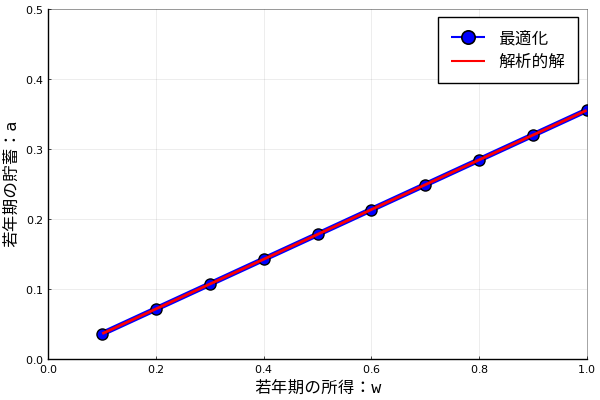

In [13]:
# 図2.2を再現
plt = plot(params.grid_w, a_gs,
    color = :blue,
    marker = :circle,
    legend = :topright,
    xlims = (0, 1.0),
    ylims = (0, 0.5),
    label = ("最適化"),
    xlabel = ("若年期の所得：w"),
    ylabel = ("若年期の貯蓄：a"),
    linewidth = 4,
    markersize = 8,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(params.grid_w, a_cfs, linewidth = 2, color = :red, label="解析的解" )
#savefig("Fig2_pol_optimization.pdf")

---

## エクササイズ
* グリッドサイズを変更して、計算時間がどの程度変わるのかを確認してみよう
* 前節で学習した操作変数を離散化する場合と比較して、計算時間がどの程度違うのかを確認してみよう。